In [4]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train/255

5

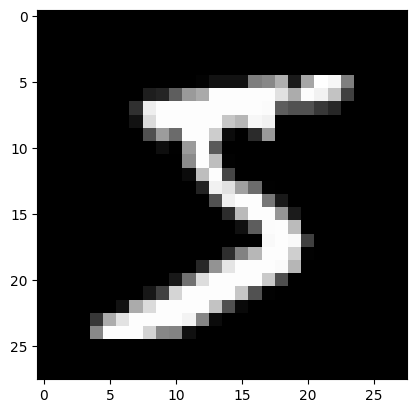

In [6]:
plt.imshow(x_train[0], cmap="gray")
y_train[0]

In [49]:
class VAE(keras.Model):
    def __init__(self, latent_dim=2):
        super().__init__()
        # encoder
        self.h1 = layers.Dense(128, activation="relu")
        
        # sampler
        self.enc_mu = layers.Dense(latent_dim)
        self.enc_log_var = layers.Dense(latent_dim)

        # decoder
        self.h3 = layers.Dense(128, activation="relu")
        self.h4 = layers.Dense(784, activation="sigmoid")

    def call(self, x):
        # encode
        x = self.h1(x)
        mean = self.enc_mu(x)
        log_var = self.enc_log_var(x)
        stddev = ops.exp(0.5*log_var)
        batch = ops.shape(mean)[0]
        dim = ops.shape(mean)[1]
        eps = keras.random.normal(shape=(batch, dim))
        z = mean + eps*stddev

        # decode
        x = self.h3(z)
        x = self.h4(x)

        return x, z, mean, log_var

class AETrainer(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.flatten = layers.Flatten(input_shape=(28, 28, 1))
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_term_tracker = keras.metrics.Mean(name="kl_term")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    
    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker, self.kl_term_tracker, self.total_loss_tracker]
    
    def train_step(self, data):
        # forward
        with tf.GradientTape() as tape:
            x = self.flatten(data)
            x_hat, _, mean, log_var = self.model(x)
            kl_term = -0.5*(ops.sum(1 + log_var - mean**2 - ops.exp(log_var), axis=-1))
            recon = ops.sum((x-x_hat)**2, axis=-1)
            loss = ops.mean(recon) + ops.mean(kl_term)
            
        # learn
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update metrics to show during training
        self.reconstruction_loss_tracker.update_state(recon)
        self.kl_term_tracker.update_state(kl_term)
        self.total_loss_tracker.update_state(loss)
        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_term": self.kl_term_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }


ae = VAE(latent_dim=2)
t = AETrainer(ae)
t.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
t.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_term: 7.1689 - reconstruction_loss: 69.3912 - total_loss: 76.5601
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_term: 2.8173 - reconstruction_loss: 43.4429 - total_loss: 46.2602
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_term: 2.9597 - reconstruction_loss: 41.0037 - total_loss: 43.9634
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_term: 3.1430 - reconstruction_loss: 39.9509 - total_loss: 43.0939
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_term: 3.2494 - reconstruction_loss: 39.2541 - total_loss: 42.5036
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 3.3675 - reconstruction_loss: 38.6348 - total_loss: 42.0023
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 3.4428 - reconstruction_loss: 38.2550 - total_loss: 41.6978
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 3.5092 - reconstruction_loss: 37.8930 - total_loss: 41.4022
Epoch 9/30
469/4

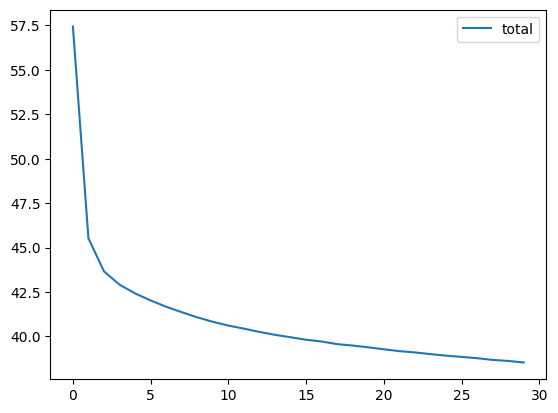

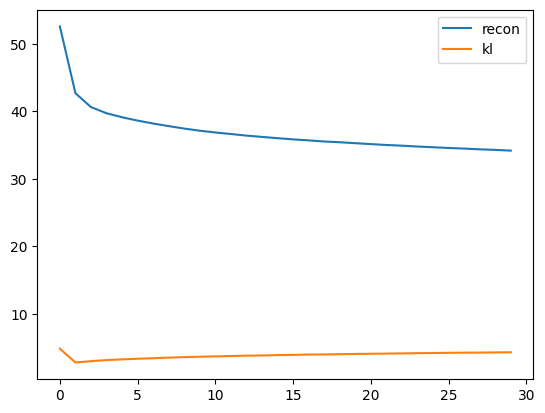

In [50]:
plt.plot(t.history.history["total_loss"], label="total")
plt.legend()
plt.show()
plt.plot(t.history.history["reconstruction_loss"], label="recon")
plt.plot(t.history.history["kl_term"], label="kl")
plt.legend()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


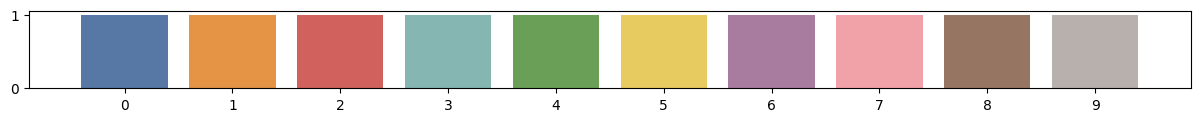

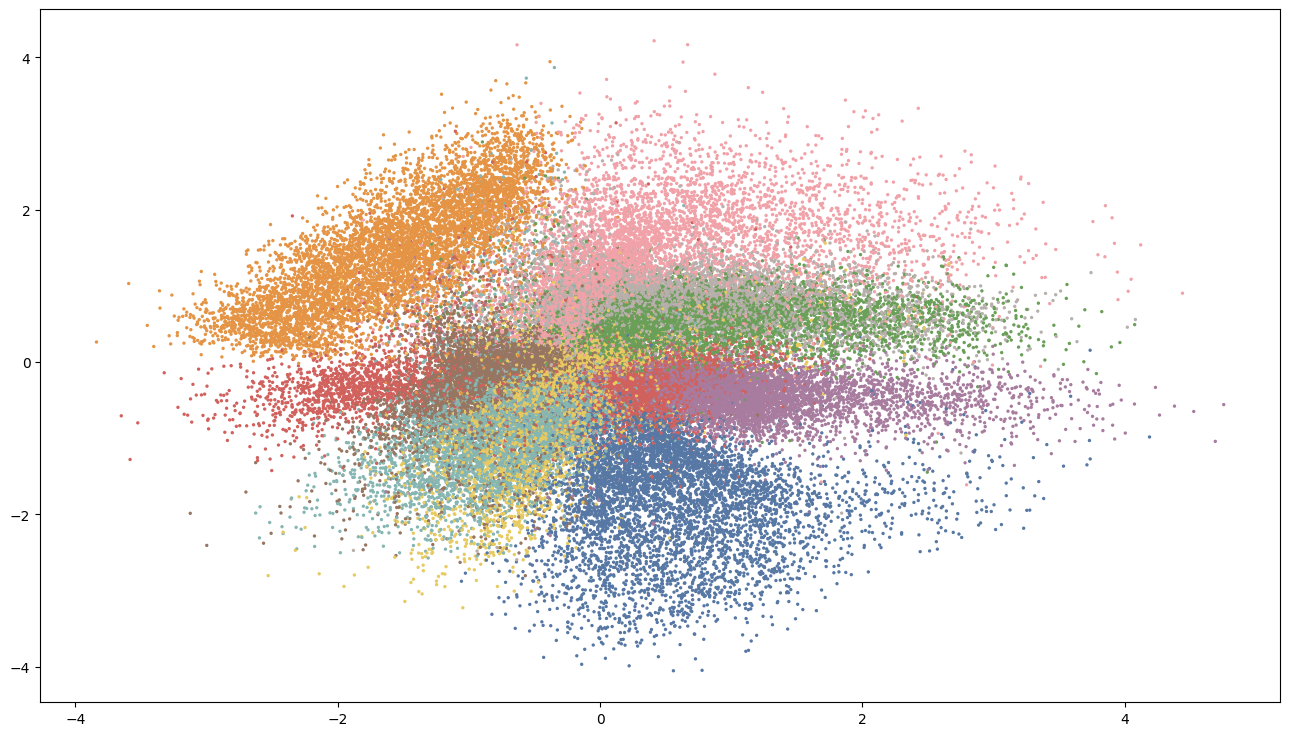

In [51]:
# now visualize the embedding space
def compute_embeddings(model, x_train, y_train):
	_, latents, _, _ = model.predict(x_train.reshape(-1, 784))
	return latents, y_train

def custom_legend(colors, labels):
	fig, ax = plt.subplots()
	fig.set_figwidth(15)
	fig.set_figheight(1)
	ax.bar(labels, [1 for i in range(len(labels))], label=labels, color=colors)
	return ax

def plot_mnist(latents, labels):
	tab10 = ["#5778a4", "#e49444", "#d1615d", "#85b6b2", "#6a9f58", "#e7ca60", "#a87c9f", "#f1a2a9", "#967662", "#b8b0ac"]
	custom_legend(tab10, [str(i) for i in range(10)])
	plt.show()
	plt.figure(figsize=(16, 9))
	plt.scatter(latents[:, 0], latents[:, 1], c=[tab10[i] for i in labels.tolist()], s=2, alpha=1)

latents, labels = compute_embeddings(ae, x_train, y_train)
plot_mnist(latents, labels)